## Project 3

Store Analysis

In [1]:
# Import Packages

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

%matplotlib inline

In [2]:
liquor = pd.read_csv('../../../Iowa_Liquor_Sales_reduced.csv') # Read in CSV

/Users/sebozek/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
liquor.shape                                                   # Determine shape of the matrix

(2709552, 18)

In [4]:
liquor[liquor.isnull().any(axis=1)]

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
4,03/31/2016,5240,WEST BRANCH,52358,NaN,NaN,1081200.0,CREAM LIQUEURS,305,73055,Rumchata,750,$12.50,$18.75,6,$112.50,4.50,1.19
114,03/31/2016,5240,WEST BRANCH,52358,NaN,NaN,1011300.0,TENNESSEE WHISKIES,85,86670,Jack Daniel's Tennessee Honey,750,$15.07,$22.61,3,$67.83,2.25,0.59
209,03/31/2016,5240,WEST BRANCH,52358,NaN,NaN,1081400.0,TRIPLE SEC,65,82606,Dekuyper Sour Apple Pucker,750,$6.30,$9.45,3,$28.35,2.25,0.59
271,03/31/2016,5240,WEST BRANCH,52358,NaN,NaN,1081200.0,CREAM LIQUEURS,260,68034,Bailey's Original Irish Cream,375,$7.00,$10.50,3,$31.50,1.12,0.30
288,03/31/2016,5240,WEST BRANCH,52358,NaN,NaN,1081600.0,WHISKEY LIQUEUR,421,64864,Fireball Cinnamon Whisky,375,$5.33,$8.00,6,$48.00,2.25,0.59
290,03/31/2016,5240,WEST BRANCH,52358,NaN,NaN,1081300.0,PEPPERMINT SCHNAPPS,434,81196,Paramount Peppermint Schnapps Traveler,750,$3.75,$5.63,3,$16.89,2.25,0.59
296,03/31/2016,5240,WEST BRANCH,52358,NaN,NaN,1022100.0,TEQUILA,395,87408,Jose Cuervo Especial Silver,750,$10.49,$15.74,6,$94.44,4.50,1.19
323,03/31/2016,5240,WEST BRANCH,52358,NaN,NaN,1062310.0,SPICED RUM,240,45886,Sailor Jerry Spiced Navy Rum,750,$9.65,$14.48,3,$43.44,2.25,0.59
376,03/31/2016,5240,WEST BRANCH,52358,NaN,NaN,1051010.0,AMERICAN GRAPE BRANDIES,259,52316,Christian Bros Brandy,750,$5.92,$8.88,3,$26.64,2.25,0.59
379,03/31/2016,5240,WEST BRANCH,52358,NaN,NaN,1062200.0,PUERTO RICO & VIRGIN ISLANDS RUM,434,45275,Paramount White Rum Traveler,750,$4.00,$6.00,6,$36.00,4.50,1.19


In [8]:
liquor = liquor.dropna(axis=0, how='any') # Drop any row that contains a NaN value

In [9]:
liquor.shape                              # observe changed shape

(2692602, 18)

## Exploratory Analysis

*Look to clean up data, and run initial tests*

In [10]:
columns = liquor.columns.values      # Pull columns

In [11]:
new_cols = []                        # Create new list for assignment
for column in columns:
    col = re.sub('\s+', '_', column) # Replace spaces with Underscores
    col = re.sub('[()]','',col)      # Replace paren with emptyspace
    new_cols.append(col)             # Add to columns list

In [12]:
liquor.columns = new_cols            # Assign Current Columns to New Name

In [13]:
liquor.head()                        # Look at head of the dataframe

,Date,Store_Number,City,Zip_Code,County_Number,County,Category,Category_Name,Vendor_Number,Item_Number,Item_Description,Bottle_Volume_ml,State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Sale_Dollars,Volume_Sold_Liters,Volume_Sold_Gallons
0,03/31/2016,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,370,87152,Avion Silver,375,$9.99,$14.99,12,$179.88,4.50,1.19
1,03/31/2016,5029,DAVENPORT,52806,82.0,Scott,1022100.0,TEQUILA,395,89197,Jose Cuervo Especial Reposado Tequila,1000,$12.50,$18.75,2,$37.50,2.00,0.53
2,03/31/2016,4959,CEDAR FALLS,50613,7.0,Black Hawk,1071100.0,AMERICAN COCKTAILS,380,63959,Uv Blue Raspberry Lemonade Pet,1750,$5.97,$8.96,6,$53.76,10.50,2.77
3,03/31/2016,2190,DES MOINES,50314,77.0,Polk,1031200.0,VODKA FLAVORED,205,40597,New Amsterdam Red Berry,200,$2.24,$3.36,48,$161.28,9.60,2.54
5,03/31/2016,4988,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,260,17090,Bulleit Bourbon 10YR,750,$23.00,$34.50,1,$34.50,0.75,0.20


In [14]:
dollar_columns = ['State_Bottle_Cost',      # Pull cols with dollar values
                  'State_Bottle_Retail', 
                  'Sale_Dollars']

liquor[dollar_columns] = \
liquor[dollar_columns].replace(             # Replace:
    '[\$,]',                                # Dollar signs with:
    "",regex=True                           # Empty Space and
).astype(float)                             # Assign to float

In [15]:
# print liquor[liquor['County'] == np.NaN]

In [16]:
liquor.dtypes # assess conversion

Date                    object
Store_Number             int64
City                    object
Zip_Code                object
County_Number          float64
County                  object
Category               float64
Category_Name           object
Vendor_Number            int64
Item_Number              int64
Item_Description        object
Bottle_Volume_ml         int64
State_Bottle_Cost      float64
State_Bottle_Retail    float64
Bottles_Sold             int64
Sale_Dollars           float64
Volume_Sold_Liters     float64
Volume_Sold_Gallons    float64
dtype: object

*Will be focusing on a County level of sales to determine what counties are worth focusing on. Because of that will be creating new dataframe that contains truncated list. 
Need to also turn date into a datetime object."

# Data Dictionary

|Name|Description|Variable Type|
|--|--|--|
|Date|Date The Transaction Took Place|Ordinal|
|Store_Number|Unique Numerical ID for Liquor Stores in Iowa|Ordinal|
|City|City Where Store is Based|Categorical|
|Zip_Code|Zip Code of Store Location|Ordinal|
|County_Number|The County's Number as Assigned by the State of Iowa|Ordinal|
|County|County Name|Categorical|
|Category|Unique Numerical ID for Category of Sale|Ordinal|
|Category_Name|Category of Alcohol Sold|Categorical|
|Vendor_Number|Unique Numerical ID assigned to Vendor|Ordinal|
|Item_Number|Unique Numerical ID of the Item Sold|Ordinal|
|Item_Description|Description of the Item Sold|Categorical
|Bottle_Volume_ml|Volume of the Bottle Sold|Interval|
|State_Bottle_Cost|Cost of Bottle|Interval|
|State_Bottle_Retail|Cost of Bottle at Retail|Interval|
|Bottles_Sold|Number of Bottles Sold in Transaction|Ordinal|
|Sale_Dollars|Total Price of Sale in Dollars|Interval|
|Volume_Sold_Liters|Volume of Alcohol Sold in Liters|Interval|
|Volume_Sold_Gallons|Volume of Alcohol Sold in Gallons|Interval|


In [17]:
liquor['Date'] = pd.to_datetime(liquor['Date'], format='%m/%d/%Y')                   # Convert to DateTime

In [18]:
liquor = liquor[['Date',                                          # Sale dates to split into 2015/2016
                 'County_Number', 'Store_Number',                  # County  & Store identifiers
                 'State_Bottle_Cost', 'State_Bottle_Retail',      # Costs of bottles sold
                 'Bottles_Sold', 'Volume_Sold_Liters',            # Measures of how much was sold
                 'Sale_Dollars'                                   # Amount of total sales
                ]]

In [19]:
liquor.head()

,Date,County_Number,Store_Number,State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Volume_Sold_Liters,Sale_Dollars
0,2016-03-31,82.0,5029,9.99,14.99,12,4.50,179.88
1,2016-03-31,82.0,5029,12.50,18.75,2,2.00,37.50
2,2016-03-31,7.0,4959,5.97,8.96,6,10.50,53.76
3,2016-03-31,77.0,2190,2.24,3.36,48,9.60,161.28
5,2016-03-31,7.0,4988,23.00,34.50,1,0.75,34.50


# Modified Data Dictionary

|Name|Description|Variable Type|
|--|--|--|
|Date|Date The Transaction Took Place|Ordinal|
|County_Number|The County's Number as Assigned by the State of Iowa|Ordinal|
|County|County Name|Categorical|
|State_Bottle_Cost|Cost of Bottle|Interval|
|State_Bottle_Retail|Cost of Bottle at Retail|Interval|
|Bottles_Sold|Number of Bottles Sold in Transaction|Ordinal|
|Sale_Dollars|Total Price of Sale in Dollars|Interval|
|Volume_Sold_Liters|Volume of Alcohol Sold in Liters|Interval|

KeyboardInterrupt: 

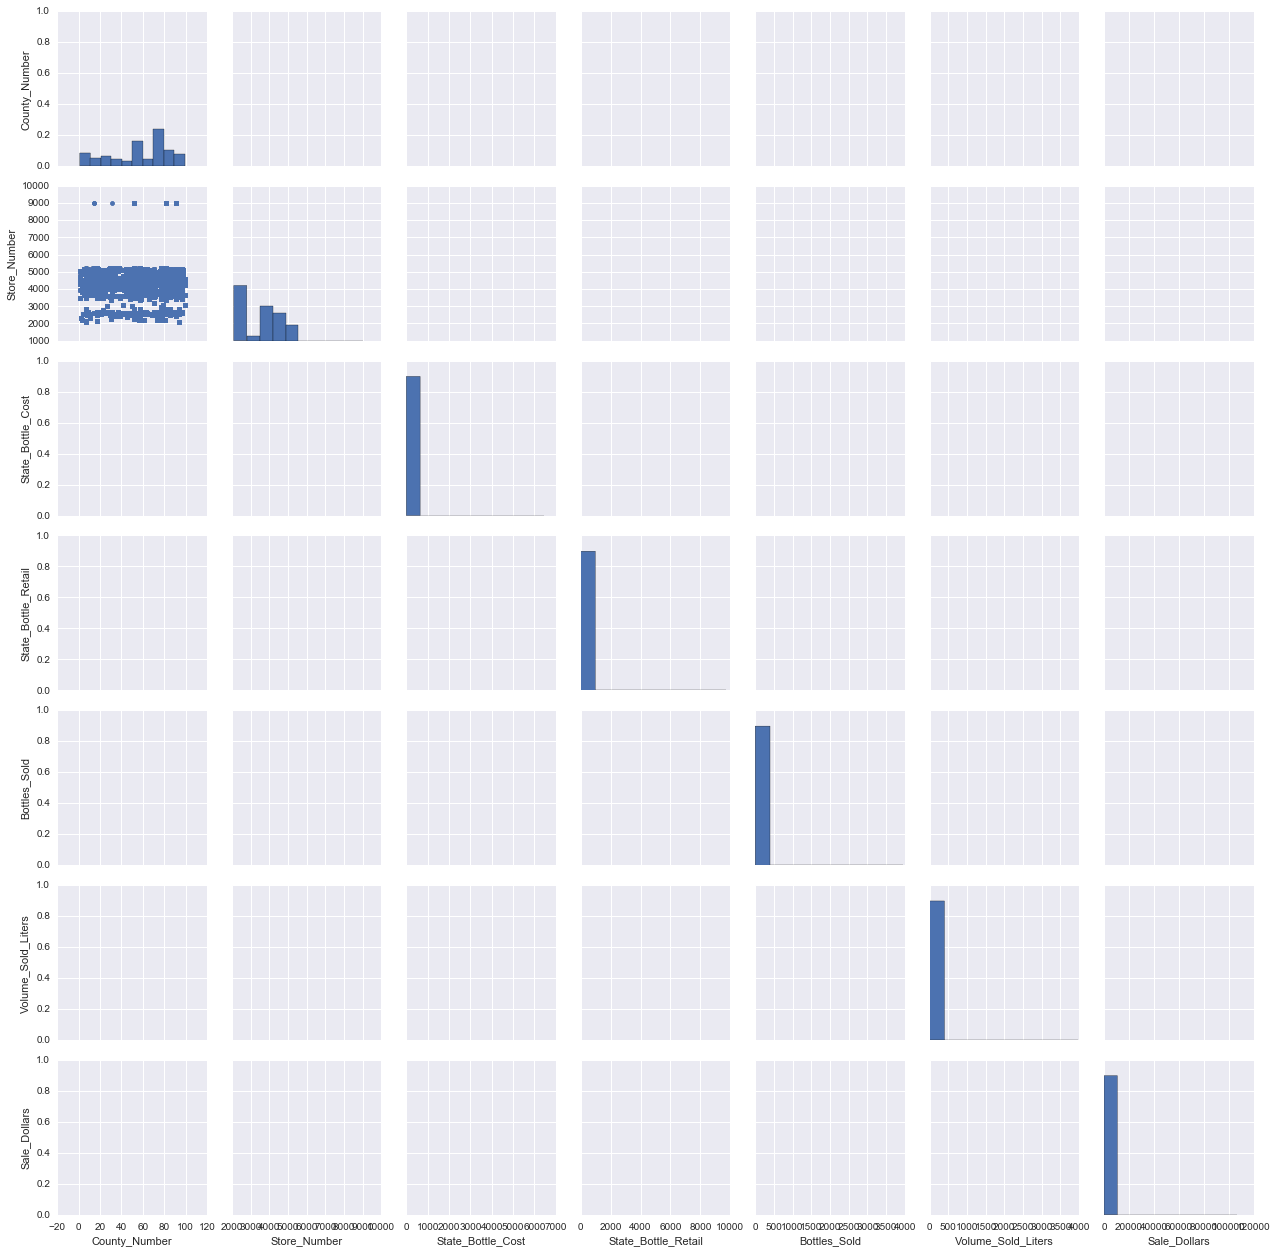

In [20]:
sns.pairplot(liquor, kind='reg')

In [23]:
# Create a 2015 and 2016 dataframe for future ref

liquor['Year'] = liquor['Date'].map(lambda x: x.year)

In [28]:
sale_Dollars = liquor[['County_Number','Sale_Dollars','Date']].groupby('Date')

In [88]:
sale_Dollars.tail()

,,Sale_Dollars
Date,County_Number,
2016-03-17,99.0,176.64
2015-06-01,8.0,142.56
2015-02-11,37.0,89.16
2015-10-08,56.0,51.00
2016-02-19,77.0,40.64


In [117]:
liquor.corr()

,County_Number,Store_Number,State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Volume_Sold_Liters,Sale_Dollars
County_Number,1.000000,0.006466,0.006167,0.006134,0.017942,0.007564,0.016635
Store_Number,0.006466,1.000000,-0.037046,-0.037108,0.014803,-0.016786,-0.017835
State_Bottle_Cost,0.006167,-0.037046,1.000000,0.999991,-0.030049,0.008552,0.106040
State_Bottle_Retail,0.006134,-0.037108,0.999991,1.000000,-0.029992,0.008742,0.106107
Bottles_Sold,0.017942,0.014803,-0.030049,-0.029992,1.000000,0.890731,0.836217
Volume_Sold_Liters,0.007564,-0.016786,0.008552,0.008742,0.890731,1.000000,0.840171
Sale_Dollars,0.016635,-0.017835,0.106040,0.106107,0.836217,0.840171,1.000000


In [ ]:
# (liquor_test['Sale_Dollars'][liquor_test['Sale_Dollars'] < 15000]).sum()
(liquor['Sale_Dollars'][liquor['Sale_Dollars'] < 10000]).sum()

In [ ]:
(liquor['Sale_Dollars'][liquor['Sale_Dollars'] > 10000]).sum()

In [ ]:
liquor['State_Bottle_Cost'].describe()

In [ ]:
liquor['State_Bottle_Retail'].describe()

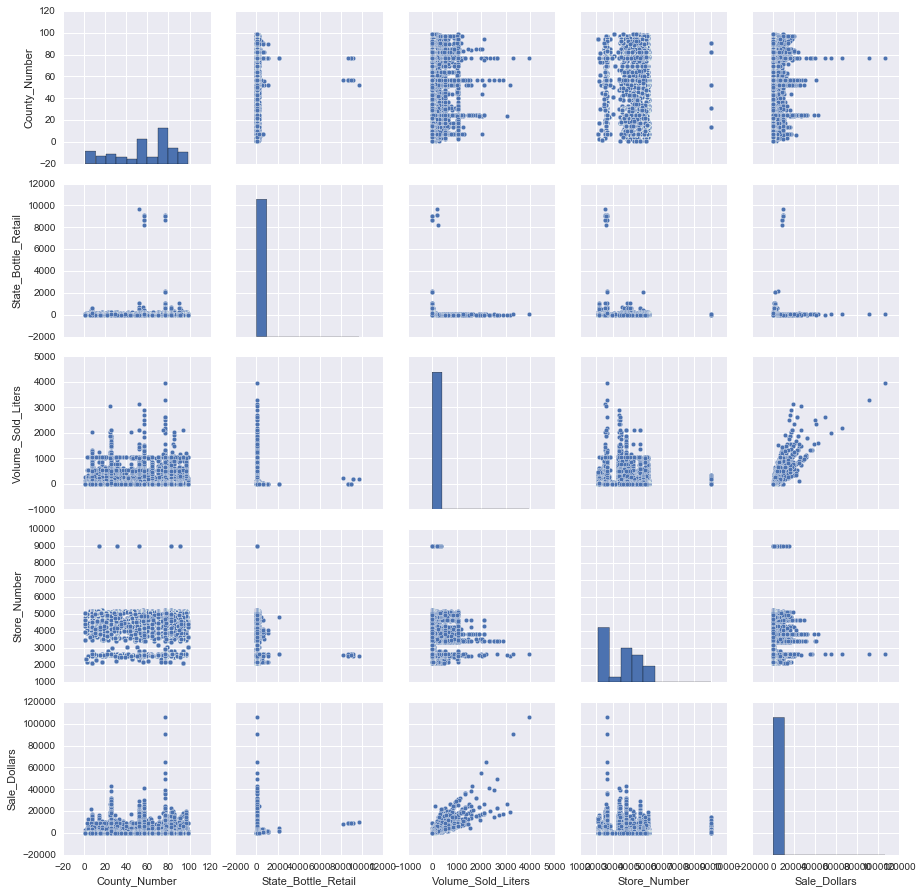

In [110]:
sns.pairplot(liquor[['County_Number','State_Bottle_Retail','Volume_Sold_Liters', 'Store_Number', 'Sale_Dollars']])

*From above it looks like there is relatively strong correlation between volume sold and sale_dollars, however it does seem like there is a high degree of heteroscedasticity.
Also looks like there may be a 'test' store number in the 9000 range that will have to be looked at and removed if that is the case*

In [ ]:
liquor[liquor['Store_Number']>8000].head()

*The stores in the 9000 range are not test values and are operating stores.*

In [86]:
liquor['Purchase_Margins'] = ( liquor['Sale_Dollars'],      # Determine total sale
                              - (liquor['State_Bottle_Cost']
                              * liquor['Bottles_Sold']))     # Find cost of bottles

ValueError: Length of values does not match length of index

In [35]:
liquor.head()

,Date,County_Number,Store_Number,State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Volume_Sold_Liters,Sale_Dollars,Year,Purchase_Margins
0,2016-03-31,82.0,5029,9.99,14.99,12,4.50,179.88,2016,2038.68
1,2016-03-31,82.0,5029,12.50,18.75,2,2.00,37.50,2016,50.00
2,2016-03-31,7.0,4959,5.97,8.96,6,10.50,53.76,2016,286.74
3,2016-03-31,77.0,2190,2.24,3.36,48,9.60,161.28,2016,7633.92
5,2016-03-31,7.0,4988,23.00,34.50,1,0.75,34.50,2016,11.50


(0, 100)

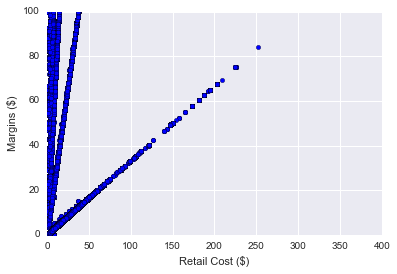

In [34]:


plt.scatter(data=liquor, x='State_Bottle_Retail', y= "Purchase_Margins")


plt.xlabel("Retail Cost ($)")
plt.ylabel("Margins ($)")
plt.xlim(0, 400)
plt.ylim(0, 100)

In [31]:
liquor2015 = liquor2015.sort(['Sale_Dollars'], ascending = False) # Order by Sales


/Users/sebozek/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


ERROR! Session/line number was not unique in database. History logging moved to new session 290


,Date,County_Number,Store_Number,State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Volume_Sold_Liters,Sale_Dollars,Year
2341103,2015-03-09,77.0,2633,17.90,26.85,3960,3960.0,106326.00,2015
1557644,2015-07-20,77.0,2633,18.38,27.57,3300,3300.0,90981.00,2015
1105245,2015-10-01,77.0,2663,15.00,22.50,2904,2178.0,65340.00,2015
582546,2015-12-23,77.0,2633,18.38,27.57,1980,1980.0,54588.60,2015
2063267,2015-04-27,77.0,2633,12.48,18.72,2640,2640.0,49420.80,2015
1054224,2015-10-12,25.0,3814,13.25,19.88,2160,1620.0,42940.80,2015
2306444,2015-03-16,57.0,3385,11.75,17.63,2328,2328.0,41042.64,2015
1806256,2015-06-09,77.0,3420,18.37,27.56,1440,2520.0,39686.40,2015
2070419,2015-04-27,25.0,3814,28.69,43.04,900,1575.0,38736.00,2015
1103349,2015-10-01,77.0,2633,18.38,27.57,1320,1320.0,36392.40,2015


In [38]:
# Create DataFrames for 2015 and 2016

liquor2015 = liquor[liquor['Year'] == 2015]

liquor2016 = liquor[liquor['Year'] == 2016 ]

In [63]:
l15 = liquor2015.groupby('County_Number').sum() # Create sums by county
l15 = l15.sort('Sale_Dollars', axis=0, ascending=False).head(10)
l15.index

/Users/sebozek/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


Float64Index([77.0, 57.0, 82.0, 52.0, 7.0, 97.0, 78.0, 31.0, 85.0, 17.0], dtype='float64', name=u'County_Number')

From above the top ten performing counties were: [77.0, 57.0, 82.0, 52.0, 7.0, 97.0, 78.0, 31.0, 85.0, 17.0]

In [64]:
# Create list of top ten counties

counties = [77.0, 57.0, 82.0, 52.0, 7.0, 97.0, 78.0, 31.0, 85.0, 17.0]

In [95]:
for county in counties:                                  # Iterate through top ten counties
    tten = liquor2015[liquor2015['County_Number'] == county] # Create new datafrme of top ten 

In [96]:
tten.index = tten['Date']    # Set index to date
del tten['Date']             # Delete date column

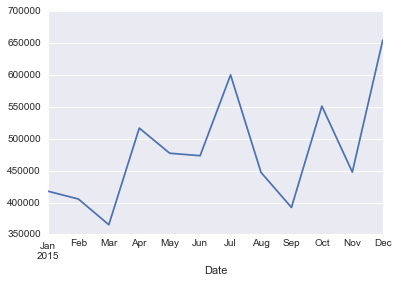

In [104]:
tten['Sale_Dollars'].resample('M').sum().plot(x='Date', y='Sale Dollars')

In [94]:
for county in counties:
    tten16 = liquor2016[liquor2016['County_Number'] == county]

In [103]:
tten16.index = tten16['Date']
del tten16['Date']

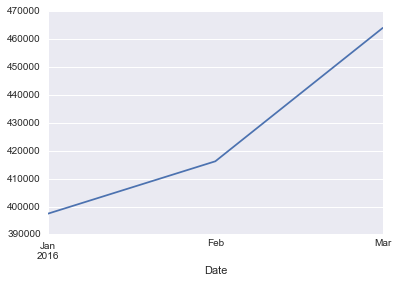

In [114]:
tten16['Sale_Dollars'].resample('M').sum().plot()